# Pulse sequence evaluation

Using arbitrary units. Energy is normalized to the standard deviation in chemical shift strengths. Reduced Planck's constant $\hbar \equiv 1$.

In [104]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

## Identify primitives

In [2]:
delay = 1e-2  # time is relative to chemical shift strength
pulse_width = 5e-3
N = 3  # number of spins

In [45]:
def get_Hsys(dipolar_strength=1e-2):
    chemical_shifts = 2*np.pi * np.random.normal(scale=1, size=(N,))
    Hcs = sum(
        [qt.tensor(
            [qt.identity(2)]*i
            + [chemical_shifts[i] * qt.sigmaz()]
            + [qt.identity(2)]*(N-i-1)
        ) for i in range(N)]
    )
    # dipolar interactions
    dipolar_matrix = 2*np.pi * np.random.normal(scale=dipolar_strength, size=(N, N))
    Hdip = sum([
        dipolar_matrix[i, j] * (
            2 * qt.tensor(
                [qt.identity(2)]*i
                + [qt.sigmaz()]
                + [qt.identity(2)]*(j-i-1)
                + [qt.sigmaz()]
                + [qt.identity(2)]*(N-j-1)
            )
            - qt.tensor(
                [qt.identity(2)]*i
                + [qt.sigmax()]
                + [qt.identity(2)]*(j-i-1)
                + [qt.sigmax()]
                + [qt.identity(2)]*(N-j-1)
            )
            - qt.tensor(
                [qt.identity(2)]*i
                + [qt.sigmay()]
                + [qt.identity(2)]*(j-i-1)
                + [qt.sigmay()]
                + [qt.identity(2)]*(N-j-1)
            )
        )
        for i in range(N) for j in range(i+1, N)
    ])
    return Hcs + Hdip

In [46]:
X = sum(
    [qt.tensor(
        [qt.identity(2)]*i
        + [qt.spin_Jx(1/2)]
        + [qt.identity(2)]*(N-i-1)
    ) for i in range(N)]
)
Y = sum(
    [qt.tensor(
        [qt.identity(2)]*i
        + [qt.spin_Jy(1/2)]
        + [qt.identity(2)]*(N-i-1)
    ) for i in range(N)]
)

In [47]:
def get_pulses(Hsys, X, Y, pulse_width, delay, rot_error=0):
    rot = np.random.normal(scale=rot_error)
    pulses = [
        qt.propagator(X * (np.pi/2) * (1 + rot) / pulse_width + Hsys, pulse_width),
        qt.propagator(Y * (np.pi/2) * (1 + rot) / pulse_width + Hsys, pulse_width),
        qt.propagator(-X * (np.pi/2) * (1 + rot) / pulse_width + Hsys, pulse_width),
        qt.propagator(-Y * (np.pi/2) * (1 + rot) / pulse_width + Hsys, pulse_width),
        qt.propagator(Hsys, pulse_width)
    ]
    delay_propagator = qt.propagator(Hsys, delay)
    pulses = [delay_propagator * i for i in pulses]
    return pulses

In [49]:
Hsys_ensemble = [get_Hsys() for _ in range(3)]
pulses_ensemble = [
    get_pulses(H, X, Y, pulse_width, delay, rot_error=0.01) for H in Hsys_ensemble
]

In [50]:
pulse_names = [
    'X', 'Y', 'Xbar', 'Ybar', 'delay'
]

In [52]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Define and evaluate pulse sequences



In [54]:
def get_fidelity(pulse_sequence, Utarget, pulses):
    Uexp = qt.identity(Utarget.dims[0])
    for p in pulse_sequence.split(','):
        Uexp = pulses[int(p)] * Uexp
    return qt.metrics.average_gate_fidelity(Uexp, Utarget)

In [55]:
def get_mean_fidelity(pulse_sequence, Utarget, pulses_ensemble):
    fidelity = 0
    for pulses in pulses_ensemble:
        fidelity += get_fidelity(pulse_sequence, Utarget, pulses)
    return fidelity / len(pulses_ensemble)

In [35]:
def format_pulse_sequence(pulse_sequence, x='x', y='y', xbar='−x', ybar='−y'):
    pulse_sequence = pulse_sequence.replace(ybar, '3').replace(xbar, '2').replace(x, '0').replace(y, '1')
    pulse_sequence = pulse_sequence.replace(' ', '')
    return pulse_sequence

In [62]:
ideal6 = '1,0,0,1,2,2'
yxx24 = '−y, x, −x, y, −x, −x, y, −x, x, −y, x, x, y,−x,x,−y,x,x,−y,x,−x,y,−x,−x'
yxx24 = format_pulse_sequence(yxx24)
yxx48 = ('y,−x,−x,y,−x,−x,−y,x,x,y,−x,−x, −y,x,x,−y,x,x,y,'
         + '−x,−x,y,−x,−x, −y, x, x, y, −x, −x, −y, x, x, '
         + '−y, x, x, y,−x,−x,−y,x,x,y,−x,−x,−y,x,x')
yxx48 = format_pulse_sequence(yxx48)

# brute-force search
bf6 = '0,0,1,0,0,1'
bf12 = '0,0,3,0,0,3,2,2,3,2,2,3'
bfr12 = '0,3,3,0,3,3,0,1,1,0,1,1'

In [76]:
yxx48[:48]

'1,2,2,1,2,2,3,0,0,1,2,2,3,0,0,3,0,0,1,2,2,1,2,2,'

In [60]:
get_mean_fidelity(((yxx24 + ',')*2)[:-1], Utarget, pulses_ensemble)

0.9946513457377097

In [58]:
get_mean_fidelity(yxx48, Utarget, pulses_ensemble)

0.9954404240609528

In [116]:
get_mean_fidelity(((bf12 + ',')*4)[:-1], Utarget, pulses_ensemble)

0.9813734184528826

In [115]:
get_mean_fidelity(((bfr12 + ',')*4)[:-1], Utarget, pulses_ensemble)

0.9813734184528826

In [100]:
get_mean_fidelity(yxx48[12:59], Utarget, pulses_ensemble)

0.6318204351937783

In [124]:
fids = []
Uexp = qt.identity(Utarget.dims[0])
for p in ((yxx48 + ',')*1)[:-1].split(','):
    Uexp = pulses_ensemble[1][int(p)] * Uexp
    fids.append(qt.metrics.average_gate_fidelity(Uexp, Utarget))

Text(0.5, 0, 'Pulse number')

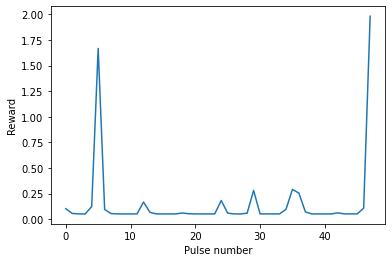

In [125]:
plt.plot(-np.log10(1-np.array(fids)))
plt.ylabel('Reward')
plt.xlabel('Pulse number')